# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import GEOparse as Geo
import seaborn as sns
from pandas.core.ops import comp_method_OBJECT_ARRAY

os.chdir('../../')
os.getcwd()

'/home/max/mcrc-cetuximab-analysis/notebooks'

# Examine raw counts/FPKM data

In [2]:
fpkms_df = pd.read_csv("../raw/GSE183984_ASAN_RNASEQ_FPKM_ensg.csv", index_col=0).T
raw_counts_df = pd.read_csv("../raw/GSE183984_ASAN_RNASEQ_raw_counts_ensg.csv", index_col=0).T

print(fpkms_df.shape)
print(raw_counts_df.shape)

# Check that columns are the same in TPM and FPKM
print(set(fpkms_df.columns) - set(raw_counts_df.columns))
print(set(raw_counts_df.columns) - set(fpkms_df.columns))

print(len(fpkms_df.columns), len(set(fpkms_df.columns)))
print(len(raw_counts_df.columns), len(set(raw_counts_df.columns)))

print(''.join(list(raw_counts_df.columns)).find('T')) # no transcript level distinction
# but somehow many genes???

(113, 58735)
(113, 58735)
set()
set()
58735 58735
58735 58735
-1


Collect ensembl gene lengths, set of ensembl protein-coding genes.

Total ensembl genes:  78932
Total ensembl protein-coding genes:  20116


<Axes: ylabel='Count'>

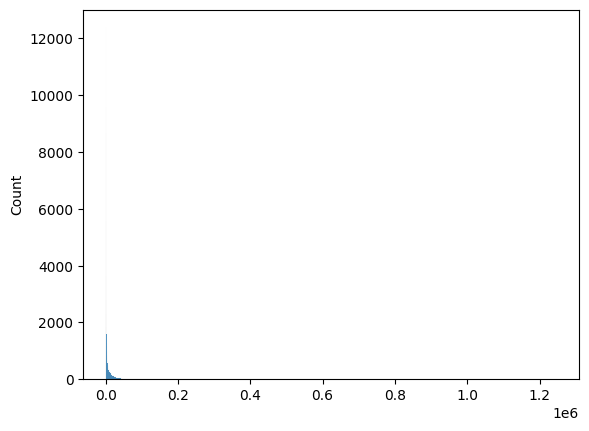

In [3]:
from collections import Counter

def parse_gtf_gene_lengths(gtf_path):
    res = Counter()
    with open(gtf_path, "r") as f:
        for li, line in enumerate(f):
            # print(line)
            if line.startswith("#"):
                continue
            parts = line.strip().split()
            if len(parts) > 10:
                if parts[2] == 'exon':
                    gene = parts[9][1:-2]
                    res[gene] += int(parts[4]) - int(parts[3]) + 1
    return res


def get_protein_coding_genes(gtf_path):
    res = set()
    with open(gtf_path, "r") as f:
        for li, line in enumerate(f):
            # print(line)
            if line.startswith("#"):
                continue
            parts = line.strip().split()
            if len(parts) > 10:
                if '"protein_coding";' in parts:
                    gene = parts[9][1:-2]
                    res.add(gene)
    return res

ensembl_gene_lengths = parse_gtf_gene_lengths('../data/Homo_sapiens.GRCh38.113.gtf')
ensembl_protein_coding_genes = get_protein_coding_genes('../data/Homo_sapiens.GRCh38.113.gtf')
print('Total ensembl genes: ', len(ensembl_gene_lengths))
print('Total ensembl protein-coding genes: ', len(ensembl_protein_coding_genes))
sns.histplot(ensembl_gene_lengths)

Find common genes: protein-coding ensembl genes that are in data, and leave only those.

In [4]:
common_ensembl_genes = ensembl_protein_coding_genes.intersection(set(raw_counts_df.columns))
print(len(common_ensembl_genes))
fpkms_df = fpkms_df[list(common_ensembl_genes)]
raw_counts_df = raw_counts_df[list(common_ensembl_genes)]
None in raw_counts_df.columns

19870


False

In [5]:
print(len(fpkms_df.columns), len(set(fpkms_df.columns)))
print(len(raw_counts_df.columns), len(set(raw_counts_df.columns)))

19870 19870
19870 19870


Rename to HUGO:

In [6]:
from time import time
import mygene

mg = mygene.MyGeneInfo()

# Example list of Ensembl gene IDs
ensembl_ids = raw_counts_df.columns

t1 = time()
# Query
result = mg.querymany(ensembl_ids, scopes="ensembl.gene", fields="symbol", species="human")
t2 = time()
print(t2-t1)

# Convert to dict: {ensembl_id: gene_symbol}
id_to_name = {item['query']: item.get('symbol', None) for item in result}
hugo_gene_lengths = {id_to_name[ensembl_name]: ensembl_gene_lengths[ensembl_name] for ensembl_name in ensembl_ids}

raw_counts_df = raw_counts_df.rename(columns=id_to_name)
fpkms_df = fpkms_df.rename(columns=id_to_name)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
2 input query terms found dup hits:	[('ENSG00000215156', 2), ('ENSG00000268674', 3)]
2 input query terms found no hit:	['ENSG00000189144', 'ENSG00000168078']


45.1054892539978


In [7]:
len(id_to_name), len(raw_counts_df.columns), len(set(raw_counts_df.columns)), len(fpkms_df.columns), len(set(fpkms_df.columns))

(19870, 19870, 19425, 19870, 19425)

In [8]:
n_none = 0
for col in raw_counts_df.columns:
    n_none += col is None
n_none

434

In [9]:
raw_counts_df = raw_counts_df.drop(columns=[None])
fpkms_df = fpkms_df.drop(columns=[None])
len(raw_counts_df.columns), len(set(raw_counts_df.columns)), len(fpkms_df.columns), len(set(fpkms_df.columns))

(19436, 19424, 19436, 19424)

In [10]:
print(len(fpkms_df.columns), len(set(fpkms_df.columns)))
print(len(raw_counts_df.columns), len(set(raw_counts_df.columns)))

19436 19424
19436 19424


In [11]:
raw_counts_df = raw_counts_df.loc[:, ~raw_counts_df.columns.duplicated()]
fpkms_df = fpkms_df.loc[:, ~fpkms_df.columns.duplicated()]
print(len(fpkms_df.columns), len(set(fpkms_df.columns)))
print(len(raw_counts_df.columns), len(set(raw_counts_df.columns)))

19424 19424
19424 19424


In [12]:
with open('../data/gnames.txt', 'r') as f:
    bg_genes = f.read().strip().split()

common_with_bg = set(raw_counts_df.columns).intersection(set(bg_genes))
len(common_with_bg)

17907

In [13]:
raw_counts_df = raw_counts_df[list(common_with_bg)]
fpkms_df = fpkms_df[list(common_with_bg)]

In [14]:
raw_counts_df.shape, fpkms_df.shape

((113, 17907), (113, 17907))

# Check & process FPKM/counts/TPM data

First need to get gene lengths

In [15]:
hugo_gene_lengths = {key: hugo_gene_lengths[key] for key in common_with_bg}
len(hugo_gene_lengths)

17907

Convert raw counts to TPM and get FPKM from counts to check if it matches.

In [23]:
def counts_to_tpm(counts):
    gl_df = pd.Series(hugo_gene_lengths)
    tpm = counts / (gl_df / 1000)
    tpm = (tpm.T / tpm.sum(axis=1)).T * 1_000_000
    print('Nans: ', tpm.isna().sum().sum())
    # print(tpm)
    return tpm

def counts_to_fpkm(counts):
    gl_df = pd.Series(hugo_gene_lengths)
    fpkm = (counts.T / counts.sum(axis=1)).T * 1_000_000
    fpkm = fpkm / (gl_df / 1000)
    print('Nans: ', fpkm.isna().sum().sum())
    # print(tpm)
    return fpkm

def fpkm_to_tpm(fpkm):
    return (fpkm.T / fpkm.sum(axis=1)).T * 1_000_000

print(raw_counts_df.shape)

tpm_df = counts_to_tpm(raw_counts_df)
tpm_from_fpkm_df = fpkm_to_tpm(raw_counts_df)

fpkm_from_counts_df = counts_to_fpkm(raw_counts_df)


(113, 17907)
Nans:  0
Nans:  0


In [24]:
fpkm_from_counts_df

name,TIFA,RUNX1T1,TTC39B,PLEK,GIMAP7,TNFSF13,GAB4,TIGD1,GPHB5,DCAF8L2,...,ZNF511,RAB5A,GDF3,RCN2,ACMSD,TCF25,LYZL6,CPEB1,SNRPD1,CDKL4
18R176_0020,0.162745,0.139840,1.280732,3.576713,8.022907,0.485197,0.0,0.406809,0.0,0.000000,...,0.429903,4.549575,0.000000,2.539891,0.364100,2.089023,0.0,0.078504,21.951294,0.076194
18R177_0021,0.100194,0.093291,1.816778,1.788271,5.682636,1.386788,0.0,0.580794,0.0,0.004356,...,1.910744,2.819348,0.000000,1.128185,0.186026,3.516479,0.0,0.010714,6.464478,0.014738
18R178_0022,0.254744,0.149932,1.892060,2.221894,5.197641,0.464008,0.0,1.860586,0.0,0.000000,...,2.120761,6.138293,0.000000,3.137258,0.321110,2.620221,0.0,0.000000,12.486414,0.070075
18R296_0008,0.317435,0.125443,1.396103,3.156558,13.331614,1.144017,0.0,0.615718,0.0,0.000000,...,2.754811,5.831145,0.045865,3.704653,0.005643,3.189362,0.0,0.000000,18.709906,0.063034
18R301_0002,0.146790,0.200216,1.510488,2.328823,10.652681,0.649139,0.0,0.665490,0.0,0.000000,...,1.180611,3.962451,0.164958,2.261494,0.156565,2.032310,0.0,0.003139,14.147113,0.107957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18R309_0015,0.105846,0.099758,1.174166,0.587459,5.127343,0.288655,0.0,0.268693,0.0,0.000000,...,1.705902,3.596912,0.021339,1.541747,3.213567,3.451893,0.0,0.003553,9.949273,0.000000
18R310_0016,0.203732,0.145604,0.877397,8.527860,8.816090,0.673187,0.0,0.372463,0.0,0.000000,...,1.208664,3.922811,0.000000,1.546610,1.937590,2.218833,0.0,0.005719,8.216245,0.093648
18R311_0018,0.097360,0.330626,1.365483,3.227153,14.154910,1.165382,0.0,0.924393,0.0,0.000000,...,1.148566,4.064405,0.000000,2.242029,0.219226,5.237751,0.0,0.010151,9.435568,0.110986
18R318_0005,0.333357,0.175838,1.559755,5.640324,8.097540,1.166122,0.0,0.375041,0.0,0.000000,...,0.362687,6.585534,1.259701,1.738690,0.109402,2.387867,0.0,0.009871,10.083008,0.000000


In [25]:
fpkms_df

,TIFA,RUNX1T1,TTC39B,PLEK,GIMAP7,TNFSF13,GAB4,TIGD1,GPHB5,DCAF8L2,...,ZNF511,RAB5A,GDF3,RCN2,ACMSD,TCF25,LYZL6,CPEB1,SNRPD1,CDKL4
18R176_0020,1.945726,7.779313,13.322034,3.700258,6.216507,5.533117,0.0,0.781820,0.0,0.000000,...,2.723805,31.375874,0.000000,28.202864,1.103180,62.182555,0.0,1.041029,153.621126,0.598431
18R177_0021,1.510585,6.772326,25.036390,2.282395,5.483556,19.172645,0.0,1.387248,0.0,0.018854,...,13.193965,21.200176,0.000000,17.056203,0.740441,107.733274,0.0,0.156501,58.665306,0.105779
18R178_0022,2.884891,8.812471,18.546892,1.995157,3.926278,4.969687,0.0,3.499684,0.0,0.000000,...,12.603614,39.930092,0.000000,40.381602,0.893399,58.776837,0.0,0.000000,77.046188,0.504310
18R296_0008,4.114573,6.433620,16.869319,3.127633,11.126653,14.203140,0.0,1.277486,0.0,0.000000,...,13.909315,45.606124,0.039569,52.198255,0.018643,98.414715,0.0,0.000000,131.493040,0.439112
18R301_0002,1.907020,8.410053,17.942158,2.810164,8.850538,8.722250,0.0,1.372179,0.0,0.000000,...,6.999428,27.376379,0.141690,28.420740,0.334668,36.203102,0.0,0.062734,101.500786,0.867676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18R309_0015,1.632769,6.789644,16.243185,0.667867,4.988159,4.129622,0.0,0.640340,0.0,0.000000,...,12.595085,28.882321,0.021469,26.567773,11.776019,104.937726,0.0,0.051263,90.224154,0.000000
18R310_0016,3.066965,15.179328,11.067240,11.053920,8.854822,8.986767,0.0,0.923970,0.0,0.000000,...,8.259389,31.073315,0.000000,22.437025,7.829559,57.853302,0.0,0.188532,71.493884,0.805180
18R311_0018,1.217008,15.994826,17.058614,3.244166,12.190216,14.843378,0.0,1.948755,0.0,0.000000,...,7.817980,27.313753,0.000000,29.110726,0.711718,121.967321,0.0,0.166531,68.230843,0.761288
18R318_0005,3.878884,7.276745,16.449506,5.105482,6.174985,12.304479,0.0,0.710867,0.0,0.000000,...,1.809869,34.209965,0.992994,23.203426,0.931510,42.852549,0.0,0.097214,67.483438,0.000000


In [26]:
tpm_df

name,TIFA,RUNX1T1,TTC39B,PLEK,GIMAP7,TNFSF13,GAB4,TIGD1,GPHB5,DCAF8L2,...,ZNF511,RAB5A,GDF3,RCN2,ACMSD,TCF25,LYZL6,CPEB1,SNRPD1,CDKL4
18R176_0020,2.222172,1.909418,17.487562,48.837694,109.547580,6.625046,0.0,5.554713,0.0,0.000000,...,5.870048,62.121487,0.000000,34.680559,4.971544,28.524246,0.0,1.071920,299.730660,1.040377
18R177_0021,1.674244,1.558904,30.358479,29.882127,94.957196,23.173317,0.0,9.705109,0.0,0.072782,...,31.928657,47.111482,0.000000,18.852042,3.108506,58.760576,0.0,0.179033,108.021828,0.246266
18R178_0022,3.649634,2.148031,27.106954,31.832383,74.464981,6.647691,0.0,26.656027,0.0,0.000000,...,30.383480,87.941397,0.000000,44.946518,4.600436,37.539080,0.0,0.000000,178.888942,1.003940
18R296_0008,4.674780,1.847363,20.560052,46.485832,196.331312,16.847654,0.0,9.067527,0.0,0.000000,...,40.569410,85.873802,0.675435,54.557487,0.083102,46.968924,0.0,0.000000,275.536066,0.928285
18R301_0002,2.113498,2.882739,21.748171,33.530661,153.378507,9.346379,0.0,9.581804,0.0,0.000000,...,16.998576,57.051821,2.375088,32.561242,2.254243,29.261424,0.0,0.045201,203.691737,1.554384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18R309_0015,1.341018,1.263881,14.876088,7.442805,64.960820,3.657115,0.0,3.404206,0.0,0.000000,...,21.612911,45.571034,0.270358,19.533147,40.714249,43.733723,0.0,0.045021,126.052205,0.000000
18R310_0016,2.638239,1.885499,11.361866,110.431716,114.164151,8.717451,0.0,4.823212,0.0,0.000000,...,15.651626,50.798525,0.000000,20.027863,25.090862,28.732829,0.0,0.074056,106.396443,1.212692
18R311_0018,1.428796,4.852053,20.038968,47.359652,207.728482,17.102408,0.0,13.565807,0.0,0.000000,...,16.855630,59.646633,0.000000,32.902601,3.217218,76.865905,0.0,0.148967,138.470405,1.628765
18R318_0005,4.942345,2.606973,23.124896,83.623345,120.053986,17.288903,0.0,5.560348,0.0,0.000000,...,5.377196,97.637011,18.676311,25.777793,1.621992,35.402475,0.0,0.146355,149.490497,0.000000


In [27]:
tpm_from_fpkm_df

name,TIFA,RUNX1T1,TTC39B,PLEK,GIMAP7,TNFSF13,GAB4,TIGD1,GPHB5,DCAF8L2,...,ZNF511,RAB5A,GDF3,RCN2,ACMSD,TCF25,LYZL6,CPEB1,SNRPD1,CDKL4
18R176_0020,1.743809,8.910436,30.006267,12.525649,9.739809,5.529787,0.0,2.715450,0.0,0.000000,...,1.934564,41.000767,0.000000,37.194160,1.828872,53.951097,0.0,2.913436,145.888299,0.616713
18R177_0021,1.073576,5.944430,42.565299,6.262527,6.898720,15.805225,0.0,3.876802,0.0,0.039762,...,8.598350,25.407965,0.000000,16.521141,0.934409,90.816575,0.0,0.397621,42.962920,0.119286
18R178_0022,2.729579,9.553528,44.329078,7.781074,6.309937,5.288294,0.0,12.419409,0.0,0.000000,...,9.543425,55.318294,0.000000,45.942011,1.612933,67.669818,0.0,0.000000,82.984708,0.567185
18R296_0008,3.401313,7.993085,32.709290,11.054266,16.184579,13.038365,0.0,4.109919,0.0,0.000000,...,12.396651,52.550280,0.056689,54.250936,0.028344,82.368454,0.0,0.000000,124.346037,0.510197
18R301_0002,1.572854,12.757593,35.389213,8.155539,12.932354,7.398239,0.0,4.442147,0.0,0.000000,...,5.312751,35.709609,0.203888,33.117313,0.786427,52.486427,0.0,0.116508,94.021712,0.873808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18R309_0015,1.134142,6.356472,27.509543,2.057281,6.224595,3.289804,0.0,1.793527,0.0,0.000000,...,7.676560,32.415367,0.026375,22.577343,16.141745,89.148590,0.0,0.131877,66.122865,0.000000
18R310_0016,2.182994,9.277723,20.556524,29.864567,10.702733,7.672313,0.0,2.486187,0.0,0.000000,...,5.438990,35.352371,0.000000,22.648560,9.732514,57.303585,0.0,0.212236,54.605163,0.757984
18R311_0018,1.043214,21.067137,31.991911,11.301490,17.184061,13.281859,0.0,6.170324,0.0,0.000000,...,5.168548,36.628420,0.000000,32.832278,1.101171,135.270145,0.0,0.376716,62.708782,0.898324
18R318_0005,3.571920,11.204229,36.543493,19.752414,9.830413,13.290291,0.0,2.503397,0.0,0.000000,...,1.632093,59.348831,1.556991,25.461381,0.549526,61.669052,0.0,0.366351,67.011668,0.000000


Check that FPKM is correct (sums to 1 after multiplying by gene length and dividing on 10^6)

In [29]:
# should be sum 1 in every row
print((fpkm_from_counts_df * (pd.Series(hugo_gene_lengths) / 1000)).sum(axis=1) / 10 ** 6)
print((fpkms_df * (pd.Series(hugo_gene_lengths) / 1000)).sum(axis=1) / 10 ** 6)

18R176_0020    1.0
18R177_0021    1.0
18R178_0022    1.0
18R296_0008    1.0
18R301_0002    1.0
              ... 
18R309_0015    1.0
18R310_0016    1.0
18R311_0018    1.0
18R318_0005    1.0
18R319_0014    1.0
Length: 113, dtype: float64
18R176_0020    15.372346
18R177_0021    14.418203
18R178_0022    15.137285
18R296_0008    15.532010
18R301_0002    15.926841
                 ...    
18R309_0015    17.891097
18R310_0016    18.390962
18R311_0018    15.847393
18R318_0005    14.750593
18R319_0014    15.424182
Length: 113, dtype: float64


Get log-tpms and plot gene expression distribution for individual sample / average

(0.0, 1000.0)

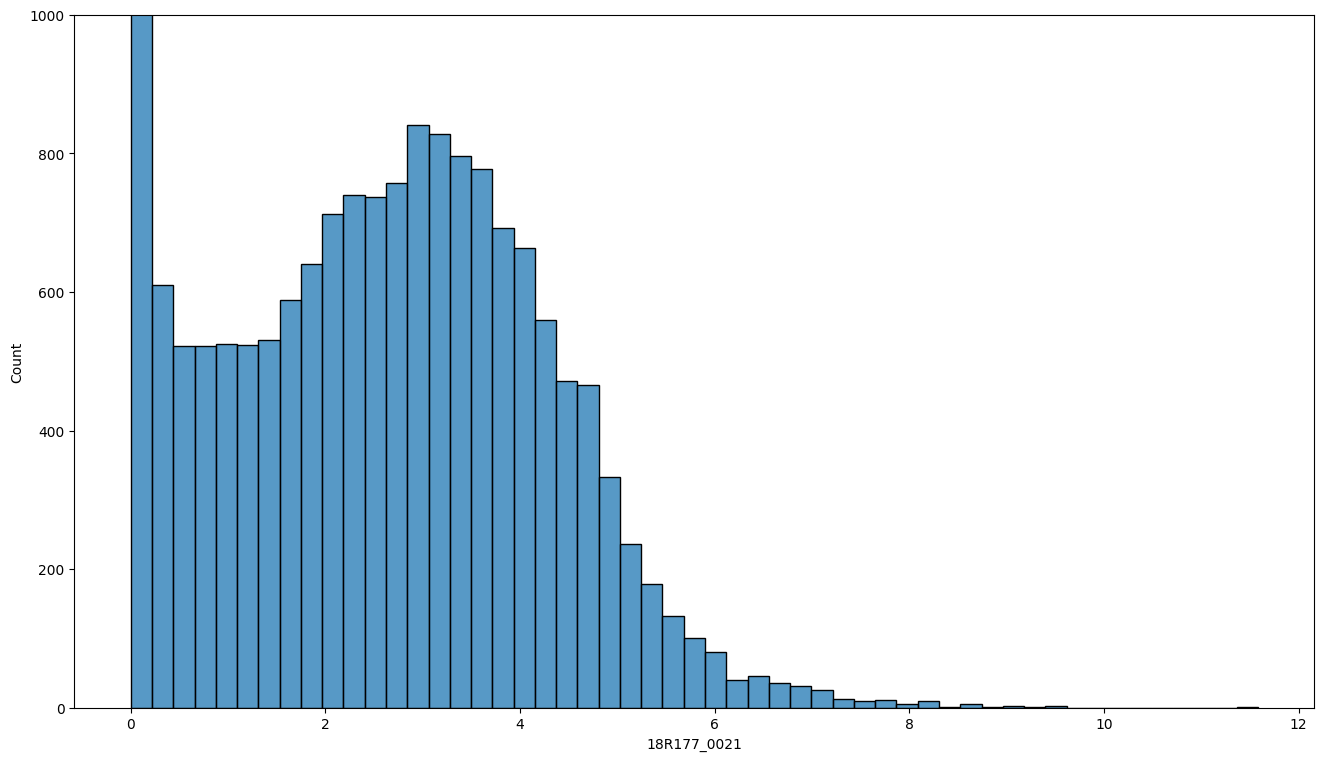

In [35]:
log_tpm_df = tpm_df.apply(lambda x: np.log(1 + x))
plt.figure(figsize=(16, 9))
sns.histplot(log_tpm_df.iloc[1])
plt.ylim(0, 1000)

(0.0, 1000.0)

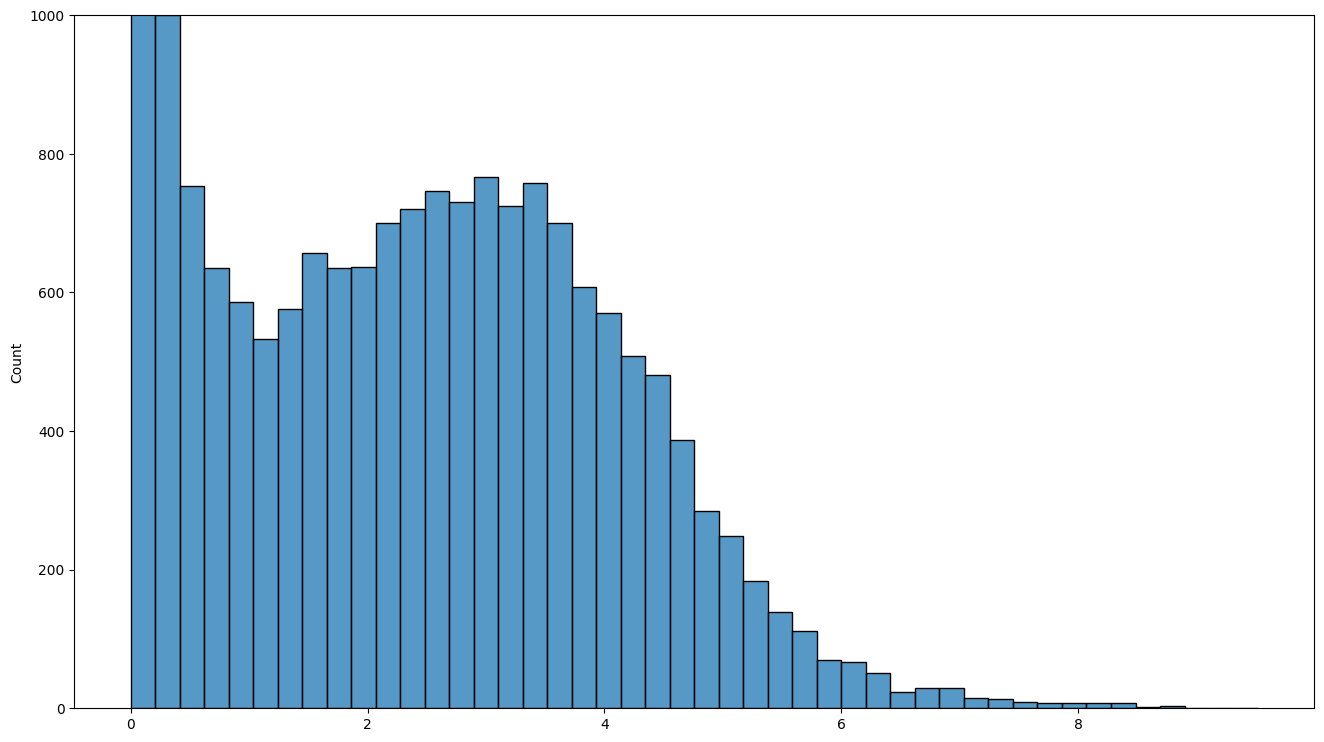

In [36]:
plt.figure(figsize=(16, 9))
sns.histplot(log_tpm_df.mean())
plt.ylim(0, 1000)